In [54]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

In [30]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

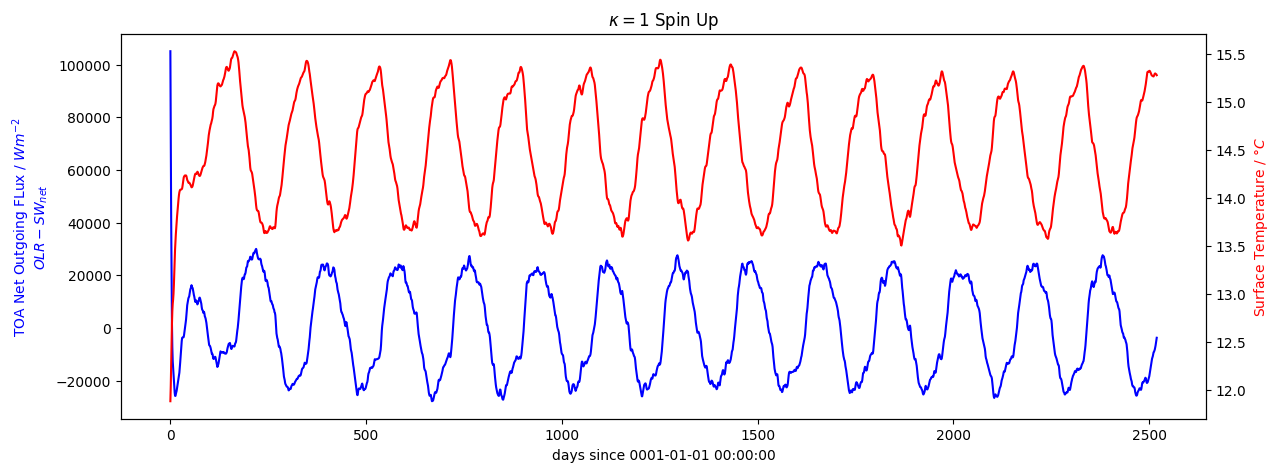

In [48]:
# Plot spin up time
spin_up_ind = np.where(np.asarray(tau_lw)==1)[0][0]     # Use dataset with earthlike optical depth for spin up plot
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds[spin_up_ind].olr, frierson_net_toa_sw_dwn(ds[spin_up_ind].swdn_toa, ds[spin_up_ind].ps,
                                                                          albedo[spin_up_ind], tau_sw[spin_up_ind]),
                             ds[spin_up_ind].t_surf, ax)
plt.title('$\kappa = 1$ Spin Up');

## Moist static energy
Want to see whether moist static energy is conserved i.e. same at surface and in free troposphere for each latitude.

In [60]:
# Compute Global Average Surface Temperature
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
temp_av = np.zeros(n_exp)
for i in range(n_exp):
    temp_av[i] = area_weighting(ds[i].sel(time=slice(use_time_start, np.inf)).t_surf).mean(dim=['lon', 'lat', 'time']).to_numpy()


In [93]:
# Compute quantile surface temperature across longitude and time dimension for each latitude
quantiles = [90, 99, 99.9, 99.99]
n_quantiles = len(quantiles)
latitudes = ds[0].lat.to_numpy()
n_latitude = len(latitudes)
weights = np.cos(np.deg2rad(latitudes))
temp_quant = np.zeros((n_exp, n_quantiles, n_latitude))
for i in range(n_exp):
    # Collapse longitude and time dimensions because they are all equivalent in an aquaplanet (expect for the seasonality).
    data_use = ds[i].sel(time=slice(use_time_start, np.inf)).t_surf.stack(lon_time=("lon","time"),
                                                                          create_index=False).chunk(dict(lon_time=-1))
    for j in range(n_quantiles):
        temp_quant[i, j, :] = data_use.quantile(quantiles[j]/100, dim='lon_time').to_numpy()


In [141]:
# Only consider a given latitude range
lat_min = 0
lat_max = 200
lat_use = np.where(np.logical_and(np.abs(latitudes)<lat_max, np.abs(latitudes)>=lat_min))[0]
temp_quant_use = np.average(temp_quant[:, :, lat_use], axis=2, weights = weights[lat_use])

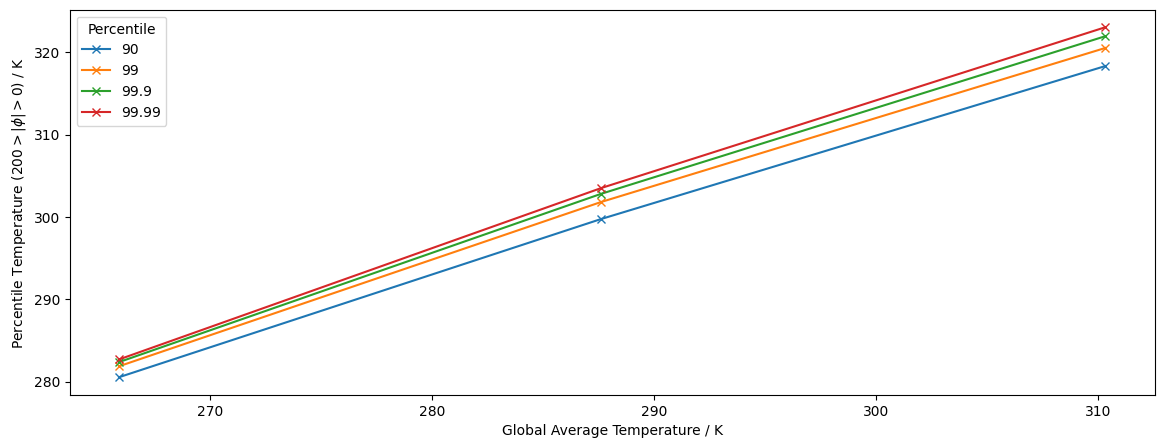

In [142]:
fig, ax = plt.subplots(1,1, figsize=(14, 5))
for j in range(n_quantiles):
    ax.plot(temp_av, temp_quant_use[:, j], marker='x', label=quantiles[j])
ax.legend(title='Percentile')
ax.set_xlabel('Global Average Temperature / K')
ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K');